In [ ]:
# ## Set up ##
# # Install simpleitk
# ! pip install SimpleITK 

# # Read gipl image using SimpleITK
# import SimpleITK as sitk
# image = sitk.ReadImage("test_trus.gipl")

# # Convert to numpy array
# import numpy as np
# image_array = sitk.GetArrayFromImage(image)

# # Save nump array as .npy file
# np.save("test_trus.npy", image_array)

In [ ]:
## Implementation of a re-slicing algorithm that obtains an image slice in a non-orthogonal plane
## reasonable for viewing prostate gland in 2D images.
# **Non-orthogonal plane**: A plane not perpendicular to the main axes of a coordinate system.
# In medical imaging, they can be used to view specific structures in a favourable orientation.
# To implement this algorithm, we need to:
# - 3D affine transformation matrix to rotate and translate the non-orthogonal plane to
# align it with original coordinate system
# - Interpolation to sample image to new coordinate points


In [1]:
import numpy as np
import matplotlib.pyplot as plt
image = np.load("test_trus.npy").T

# Apply rotation at the centre of the slice
translation_points = (np.array(image[:, :, 0].shape) - 1)/2
rotation_angle = 45

# Import interpn
from scipy.interpolate import interpn

def re_slicing(image, translation_points, rotation_angle):

    # Convert translation_points and rotation_angles to numpy arrays
    translation_points = np.array(translation_points)
    rotation_angle = np.deg2rad(np.array(rotation_angle)) # Convert to radians

    # Translation affine matrix that will be used to translate the image to the desired position
    translation_matrix = np.array([[1, 0, -translation_points[0]],
                                   [0, 1, -translation_points[1]],
                                   [0, 0, 1]])
    # Rotation affine matrix that will be used to rotate the image to the desired angle
    rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle), 0],
                                [np.sin(rotation_angle), np.cos(rotation_angle), 0],
                                [0, 0, 1]])

    # Then apply translation back to the original position
    translation_back_matrix = np.array([[1, 0, translation_points[0]],
                                        [0, 1, translation_points[1]],
                                        [0, 0, 1]])
    
    # Create a composed affine matrix
    affine_matrix = np.matmul(translation_back_matrix, np.matmul(rotation_matrix, translation_matrix))

    # Create a meshgrid of the image
    x, y = np.mgrid[:image.shape[0], :image.shape[1]]


    # Stack the x and y coordinates to create a 3D array
    coords = np.vstack((x.flatten(), y.flatten(), np.ones(x.size)))

    # Apply the affine transformation to the coordinates to find the new coordinates after translation and rotation
    coords = np.matmul(affine_matrix, coords)

    # Extract the new x and y coordinates since this is a 2D slice
    coords = coords[:2, :]

    # Reshape the new coordinates to the original shape of the slice
    new_coords = np.zeros((image.shape[0], image.shape[1], 2))
    new_coords[:, :, 0] = coords[0, :].reshape(image.shape[0], image.shape[1])
    new_coords[:, :, 1] = coords[1, :].reshape(image.shape[0], image.shape[1])

    # Apply interpolation to the new coordinates to find the new values after translation and rotation
    new_image = interpn((np.arange(image.shape[0], dtype = 'float'), np.arange(image.shape[1], dtype = 'float')),
        image, new_coords,
        method = 'linear', bounds_error = False,
        fill_value = 0)

    return new_image





# Apply re-slicing algorithm to the 3D image
re_sliced_image = re_slicing(image, translation_points, rotation_angle)

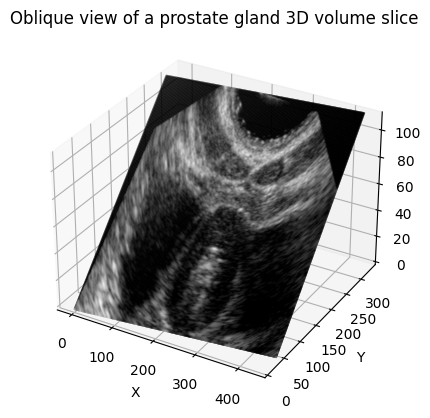

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the 3D volume of the prostate glandprostate_volume = np.load("prostate_volume.npy")
# Load the 3D volume of the prostate gland
prostate_volume = image

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the x, y, and z limits of the plot
x_len, y_len, z_len = prostate_volume.shape
ax.set_xlim(0, x_len)
ax.set_ylim(0, y_len)
ax.set_zlim(0, z_len)

# Define the transformation matrix for the oblique view
theta = np.deg2rad(-5)
phi = np.deg2rad(-20)
# translation_matrix = np.array([[1, 0, -translation_points[0]],
#                                    [0, 1, -translation_points[1]],
#                                    [0, 0, 1]])
# rotation_matrix_theta = np.array([[np.cos(theta), -np.sin(theta), 0],
#                             [np.sin(theta), np.cos(theta), 0],
#                             [0, 0, 1]])
# rotation_matrix_phi = np.array([[1, 0, 0],
#                                    [0, np.cos(phi), -np.sin(phi)],
#                                    [0, np.sin(phi), np.cos(phi)]])
# # Then apply translation back to the original position
# translation_back_matrix = np.array([[1, 0, translation_points[0]],
#                                     [0, 1, translation_points[1]],
#                                     [0, 0, 1]])
# # Create a composed affine matrix
# rotation_matrix = np.matmul(translation_back_matrix, np.matmul(rotation_matrix_phi, np.matmul(rotation_matrix_theta, translation_matrix)))


rotation_matrix_theta = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [np.sin(theta), np.cos(theta), 0],
                            [0, 0, 1]])
rotation_matrix_phi = np.array([[1, 0, 0],
                                   [0, np.cos(phi), -np.sin(phi)],
                                   [0, np.sin(phi), np.cos(phi)]])

# Create a composed affine matrix
rotation_matrix = np.matmul(rotation_matrix_phi, rotation_matrix_theta)


# Define the coordinates of the slice
slice_index = 0
xx, yy = np.meshgrid(np.arange(x_len), np.arange(y_len), indexing='ij')
zz = np.ones_like(xx) * slice_index


# Apply the transformation matrix to the coordinates
xyz = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T
xyz = np.dot(xyz, rotation_matrix)

# Reshape the transformed coordinates and the slice values
xx, yy, zz = xyz[:, 0].reshape(xx.shape), xyz[:, 1].reshape(yy.shape), xyz[:, 2].reshape(zz.shape)



# Extract the slice values
slice_values = prostate_volume[:, :, slice_index]


# Interpolate the slice values to the transformed coordinates
slice_values = interpn((np.arange(x_len), np.arange(y_len)), slice_values, np.vstack((xx.flatten(), yy.flatten())).T, method='linear', bounds_error=False, fill_value=0)

# Plot the transformed slice as a surface

# Create a 1D array of the slice values
color_values = slice_values.flatten()

# Create a 1D array of RGB colors corresponding to the intensity values
cmap = plt.cm.gray
norm = plt.Normalize(vmin=color_values.min(), vmax=color_values.max())
color_array = cmap(norm(color_values))

# Plot the transformed slice as a 3D scatter plot
ax.scatter(xx, yy, zz, c=color_array, s = 0.07)

# Calculate the minimum and maximum z-coordinates of the transformed slice
z_min = zz.min()
z_max = zz.max()
x_min = xx.min()
x_max = xx.max()
y_min = yy.min()
y_max = yy.max()

# Set the limits of the z-axis to include the entire slice
ax.set_zlim(z_min, z_max)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Set the title of the plot
ax.set_title("Oblique view of a prostate gland 3D volume slice")

# Set the labels for the x, y, and z axes
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Show the plot
plt.show()


In [16]:
image.shape

(455, 325, 46)

In [15]:
slice_values.reshape(xx.shape).shape

(455, 325)

In [17]:
color_values.shape

(147875,)

Bad pipe message: %s [b'\xb3\xa9M\x12\x17\x8c\xe5\xd0\nr\xa9Q\x0c\x9bY\xc0\xd2\xbd \xfeIQ\xff\x0b\xebR\xe1\x8dS>\x1d\xec\xee\xf8\x02']
Bad pipe message: %s [b"\xc7G\x84Q\xc0\x8a^\xf2vG\xa6\xef\xf6=\x05~\xd7K\x00\x00\xf4\xc00\xc0,\xc0(\xc0$\xc0\x14\xc0\n\x00\xa5\x00\xa3\x00\xa1\x00\x9f\x00k\x00j\x00i\x00h\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00\xa7\x00m\x00:\x00\x89\xc02\xc0.\xc0*\xc0&\xc0\x0f\xc0\x05\x00\x9d\x00=\x005\x00\x84\xc0/\xc0+\xc0'\xc0#\xc0\x13\xc0\t\x00\xa4\x00\xa2\x00\xa0\x00\x9e\x00g\x00@\x00?\x00>\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00D\x00C\x00B\xc0\x18\x00\xa6\x00l\x004\x00\x9b\x00F\xc01\xc0-\xc0)\xc0%\xc0\x0e\xc0\x04"]
Bad pipe message: %s [b'a \x95\xd6`\x9a\x03\xe7', b'Sp\xe5\x1f\xfey0n\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8', b"\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\

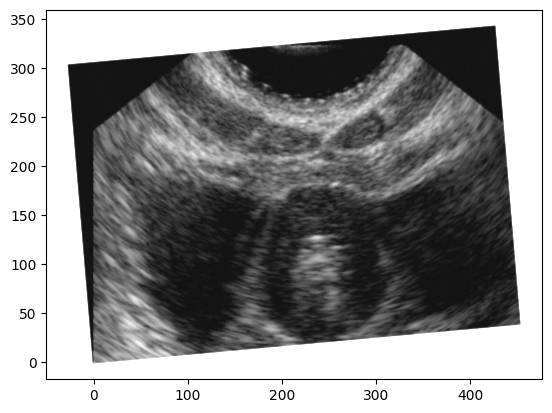

In [84]:
# Create a 1D array of the slice values
# Fill in the blanks with 0s
plt.scatter(xx, yy, c=color_array, s = 0.07)
# Set axis limits
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)

In [43]:
# Interpolate the slice values to the transformed coordinates
slice_valuesx = interpn((np.arange(x_len), np.arange(y_len)), slice_values, np.vstack((xx.flatten(), yy.flatten())).T, method='linear', bounds_error=False, fill_value=0)


In [30]:
rotation_matrix

array([[ 1.49858453e+01, -1.59815282e+02,  2.26488021e+04],
       [ 9.92217509e+00, -1.13410980e+02,  1.62355035e+04],
       [ 6.16284167e-02, -7.04416026e-01,  1.00832852e+02]])

## Visualize re-sliced examples in 2D and 3D with varying positioning parameter values.

Text(0.5, 1.0, 'Resliced')

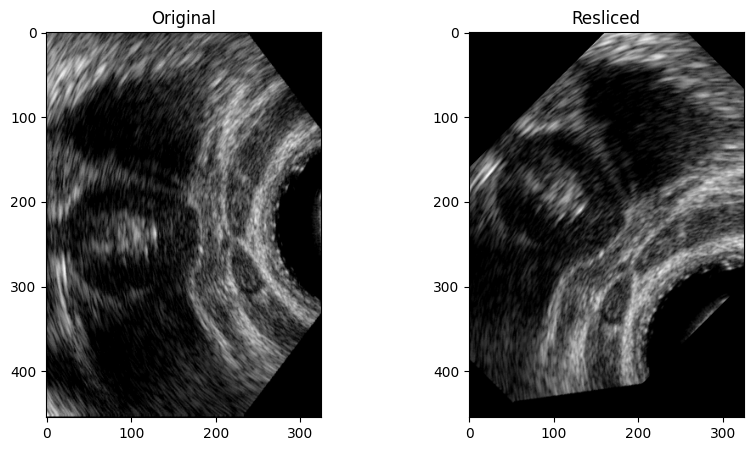

In [2]:
import matplotlib.pyplot as plt

# Visualise a slice of the original and re-sliced image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image[:,:,0], cmap='gray')
ax1.set_title('Original')
ax2.imshow(re_sliced_image[:,:,0], cmap='gray')
ax2.set_title('Resliced')

In [ ]:
# Visualize the slice in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(re_sliced_image[:, :, :1], edgecolor='k')
plt.show()

In [18]:
re_sliced_image[:, :, :1].shape

(455, 325, 1)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# generate sample data points
import numpy as np
x = np.random.rand(100)
y = np.random.rand(100)
z = np.random.rand(100)

# plot the data points
ax.scatter(x, y, z)

# set the labels for the axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# show the plot
plt.show()


In [6]:
np.array((x, y, z)).shape

(3, 100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_volume(volume):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Generate vertices for the surface of the volume
    verts = []
    for i in range(volume.shape[0] - 1):
        for j in range(volume.shape[1] - 1):
            for k in range(volume.shape[2] - 1):
                verts.append([(i, j, k), (i, j, k + 1), (i, j + 1, k + 1), (i, j + 1, k)])
                verts.append([(i, j, k), (i, j + 1, k), (i + 1, j + 1, k), (i + 1, j, k)])
                verts.append([(i, j, k + 1), (i, j + 1, k + 1), (i + 1, j + 1, k + 1), (i + 1, j, k + 1)])
                verts.append([(i + 1, j, k), (i + 1, j, k + 1), (i + 1, j + 1, k + 1), (i + 1, j + 1, k)])
    verts = np.array(verts)

    # Plot the surface of the volume
    ax.add_collection(Poly3DCollection(verts, alpha=0.25, facecolor='gray'))
    ax.set_xlim(0, volume.shape[0])
    ax.set_ylim(0, volume.shape[1])
    ax.set_zlim(0, volume.shape[2])
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()

# Generate a sample volume with the specified shape
volume = re_sliced_image[:, :, :1]
plot_volume(volume)


In [ ]:
volume

In [2]:
import SimpleITK as sitk
import numpy as np


In [ ]:

# Load the volumetric data into a numpy array
image = sitk.ReadImage("volumetric_data.nii.gz")
data = sitk.GetArrayFromImage(image)


In [46]:

# Define the transformation matrix that maps the oblique slice to the image coordinate system
# In this example, we'll rotate the slice by 45 degrees around the x-axis and translate it by (10, 20, 30)
theta = np.deg2rad(45)
R = np.array([[1, 0, 0],
              [0, np.cos(theta), -np.sin(theta)],
              [0, np.sin(theta), np.cos(theta)]])
t = np.array([0, 0, 0])
S = np.eye(4)
S[:3, :3] = R
S[:3, 3] = t
S


array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678,  0.        ],
       [ 0.        ,  0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [47]:

S = np.linalg.inv(S)
S


array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678,  0.70710678,  0.        ],
       [ 0.        , -0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [48]:
image.shape

(455, 325, 46)

In [49]:

# Define the shape of the oblique slice
shape = (455, 325)

# Define the pixel spacing of the oblique slice
spacing = (1, 1)


In [50]:


# Compute the indices of the oblique slice in the volumetric data array
indices = np.indices(shape).reshape((2, -1)).T
indices


array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [454, 322],
       [454, 323],
       [454, 324]])

In [51]:

indices = np.concatenate((indices, np.zeros((indices.shape[0], 1)), np.ones((indices.shape[0], 1))), axis=1)
indices

array([[  0.,   0.,   0.,   1.],
       [  0.,   1.,   0.,   1.],
       [  0.,   2.,   0.,   1.],
       ...,
       [454., 322.,   0.,   1.],
       [454., 323.,   0.,   1.],
       [454., 324.,   0.,   1.]])

In [52]:
indices.shape

(147875, 4)

In [53]:

indices = np.matmul(S, indices.T).T[:, :3]
indices = np.round(indices).astype(int)
indices

array([[   0,    0,    0],
       [   0,    1,   -1],
       [   0,    1,   -1],
       ...,
       [ 454,  228, -228],
       [ 454,  228, -228],
       [ 454,  229, -229]])

In [54]:

# Extract the oblique slice from the volumetric data array
slice_data = image[indices[:, 0], indices[:, 1]]

In [55]:
slice_data = slice_data.reshape(image.shape)

In [56]:
slice_data.shape

(455, 325, 46)

In [57]:
import matplotlib.pyplot as plt

# Get the pixel spacing of the oblique slice
pixel_spacing = (1, 1)

# Create a 2D meshgrid for the oblique slice
x = np.arange(0, shape[0], 1) * pixel_spacing[0]
y = np.arange(0, shape[1], 1) * pixel_spacing[1]
xx, yy = np.meshgrid(x, y)
xx


array([[  0,   1,   2, ..., 452, 453, 454],
       [  0,   1,   2, ..., 452, 453, 454],
       [  0,   1,   2, ..., 452, 453, 454],
       ...,
       [  0,   1,   2, ..., 452, 453, 454],
       [  0,   1,   2, ..., 452, 453, 454],
       [  0,   1,   2, ..., 452, 453, 454]])

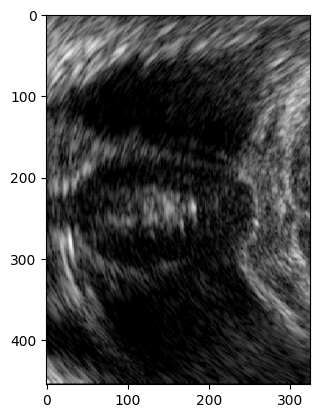

In [58]:
plt.imshow(slice_data[:, :, 0], cmap='gray')

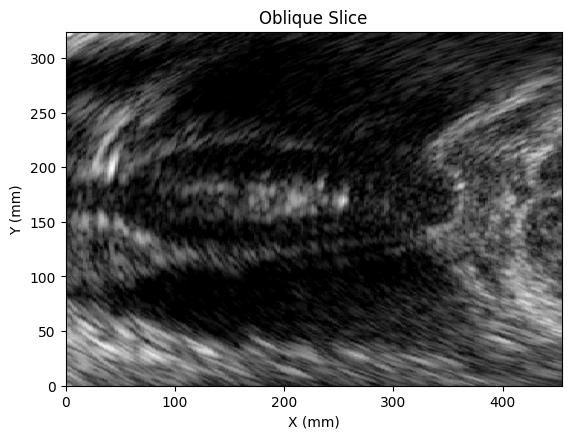

In [59]:

# Plot the oblique slice using Matplotlib
fig, ax = plt.subplots()
ax.imshow(slice_data[:, :, 0], cmap='gray', origin='lower', extent=[0, x[-1], 0, y[-1]])
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_title('Oblique Slice')
plt.show()


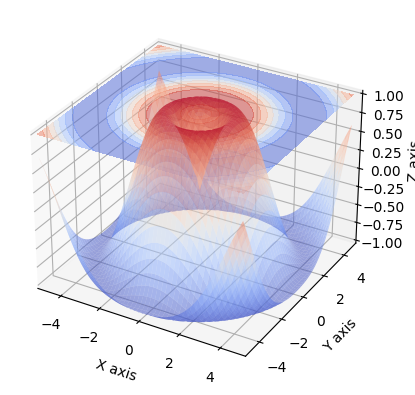

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# create data for 3D plot
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))


# plot surface and set face colors to transparent
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.5)
surf.set_facecolor((0,0,0,0))

# add slice
z_slice = 1
ax.contourf(X, Y, Z, zdir='z', offset=z_slice, cmap='coolwarm', alpha=0.5)

# set limits and labels
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-1, 1)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# show plot
plt.show()


In [70]:
tr.shape

(3, 100, 100)

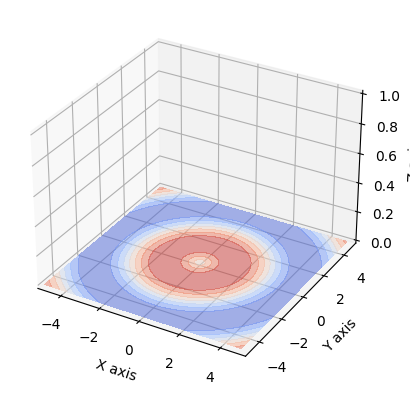

In [78]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# create data for 3D plot
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))


# plot surface and set face colors to transparent
# surf = ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.5)
# surf.set_facecolor((0,0,0,0))

# add slice
z_slice = 0
ax.contourf(X, Y, Z, zdir='z', offset=z_slice, cmap='coolwarm', alpha=0.5)

# set limits and labels
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(0, 1)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# show plot
plt.show()


In [3]:
image.shape

(455, 325, 46)

In [5]:
324/2

162.0

In [2]:
import numpy as np
from scipy.ndimage import affine_transform

# Define the 3D volume and the point of interest (POI)
volume = image # your 3D volume
poi = np.array([227, 162, 30]) # coordinates of the point of interest

# Define the normal vector of the plane that you want to slice
normal = np.array([0, 15, 20])

# Calculate the angle between the normal vector and the x, y, and z axes
angles = np.arccos(normal / np.linalg.norm(normal))
angles


array([1.57079633, 0.92729522, 0.64350111])

In [3]:

# Define the rotation matrix that will rotate the volume to align with the plane
R_x = np.array([[1, 0, 0], [0, np.cos(angles[0]), -np.sin(angles[0])], [0, np.sin(angles[0]), np.cos(angles[0])]])
R_y = np.array([[np.cos(angles[1]), 0, np.sin(angles[1])], [0, 1, 0], [-np.sin(angles[1]), 0, np.cos(angles[1])]])
R_z = np.array([[np.cos(angles[2]), -np.sin(angles[2]), 0], [np.sin(angles[2]), np.cos(angles[2]), 0], [0, 0, 1]])
R = np.dot(R_z, np.dot(R_y, R_x))
R


array([[ 4.8000000e-01,  6.4000000e-01,  6.0000000e-01],
       [ 3.6000000e-01,  4.8000000e-01, -8.0000000e-01],
       [-8.0000000e-01,  6.0000000e-01,  3.6739404e-17]])

In [4]:


# Define the plane equation
d = -np.dot(normal, poi)
plane = np.concatenate((normal, [d]))


In [24]:

# Define a function to check if a voxel position lies on the plane
def is_on_plane(pos):
    return np.abs(np.dot(pos, plane[:3]) + plane[3]) < 1e-6

# Define a function to transform a voxel position to the rotated volume
def transform_pos(pos):
    return np.dot(R, pos - poi)

# Iterate through each voxel of the volume, and for each voxel:
image_slice = np.zeros((volume.shape[0], volume.shape[1]))
for i in range(volume.shape[0]):
    for j in range(volume.shape[1]):
        for k in range(volume.shape[2]):
            # Calculate the position of the voxel in the rotated volume
            pos = np.array([i, j, k])
            pos_rot = transform_pos(pos)
            
            # Check if the voxel position lies on the plane
            if is_on_plane(pos_rot):
                # Add the value of the voxel to the image slice
                image_slice[i, j] += volume[i, j, k]


In [26]:
image_slice.shape

(455, 325)

In [ ]:

# Display the resulting image slice
plt.imshow(image_slice, cmap='gray')


In [18]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def get_prostate_slice(volume, plane_normal, plane_point, slice_shape):
    """
    Obtain a 2D image slice of the prostate gland from a 3D volume in a non-orthogonal plane.

    Args:
        volume (ndarray): 3D volume of the prostate gland.
        plane_normal (ndarray): Normal vector of the re-slicing plane.
        plane_point (ndarray): A point on the re-slicing plane.
        slice_shape (tuple): Shape of the 2D slice to extract.

    Returns:
        ndarray: A 2D slice of the prostate gland in the non-orthogonal plane.
    """
    # Calculate the intersection of the plane and the volume
    volume_shape = volume.shape
    xx, yy, zz = np.meshgrid(np.arange(volume_shape[0]), np.arange(volume_shape[1]), np.arange(volume_shape[2]), indexing='ij')
    d = np.dot(plane_normal, (np.array([xx, yy, zz]) - np.array(plane_point)[:, np.newaxis, np.newaxis, np.newaxis]))
    t = -d / np.dot(plane_normal, plane_normal)
    intersection_points = np.array([xx, yy, zz]) + np.array(plane_normal)[:, np.newaxis, np.newaxis, np.newaxis] * t

    # Extract the slice from the volume
    slice_interp = RegularGridInterpolator((np.arange(volume_shape[0]), np.arange(volume_shape[1]), np.arange(volume_shape[2])),
                                            volume, method='linear', bounds_error=False, fill_value=0)
    slice_coords = np.array([intersection_points[0].flatten(), intersection_points[1].flatten(), intersection_points[2].flatten()]).T
    slice_data = slice_interp(slice_coords).reshape(slice_shape)

    return slice_data


In [2]:

volume = image
volume.shape

(455, 325, 46)

In [3]:
plane_normal = np.array([1, 0, 1])
plane_normal = plane_normal/np.linalg.norm(plane_normal)  # normalize the plane normal vector
plane_point = np.array([20, 40, 60])
slice_shape = (455, 325)

In [4]:
volume_shape = volume.shape
xx, yy, zz = np.meshgrid(np.arange(volume_shape[0]), np.arange(volume_shape[1]), np.arange(volume_shape[2]), indexing='ij')

In [5]:
d = np.sum(plane_normal[:, np.newaxis, np.newaxis, np.newaxis] * (np.array([xx, yy, zz]) - np.array(plane_point)[:, np.newaxis, np.newaxis, np.newaxis]), axis=0)


In [6]:

t = -d / np.dot(plane_normal, plane_normal)
t.shape

(455, 325, 46)

In [7]:

intersection_points = np.array([xx, yy, zz]) + np.array(plane_normal)[:, np.newaxis, np.newaxis, np.newaxis] * t


In [8]:
intersection_points.shape

(3, 455, 325, 46)

In [9]:
intersection_points[1].flatten().shape

(6802250,)

In [10]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
# Extract the slice from the volume
slice_interp = RegularGridInterpolator((np.arange(volume_shape[0]), np.arange(volume_shape[1]), np.arange(volume_shape[2])),
                                        volume, method='linear', bounds_error=False, fill_value=0)


In [11]:
ch = np.array([intersection_points[0].flatten(), intersection_points[1].flatten(), intersection_points[2].flatten()])


In [12]:

slice_coords = ch.T


In [13]:
interp = slice_interp(slice_coords)

: 

: 

In [12]:
slice_data = slice_interp(slice_coords).reshape(slice_shape)

: 

: 

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image


img_array = image[:, :, 0]

# Determine the orientation of the non-orthogonal plane in 3D space
v1 = np.array([1, 0, 0])
v2 = np.array([1, 1, 0])
normal = np.cross(v1, v2)


# Choose a point in the plane that you want to slice
point = np.array([img_array.shape[0]//2, img_array.shape[1]//2, 0])
point

# Choose a direction for the slice
direction = np.array([0, 0, 1])

# Calculate the intersection between the plane and the line that passes through the point and is parallel to the direction
t = -np.dot(normal, point) / np.dot(normal, direction)
intersection = point + t * direction


# Determine the size of the 2D slice
width = 455
height = 325
v3 = np.array([0, 1, -1])
v4 = np.cross(direction, v3)
x, y = np.meshgrid(np.arange(-width/2, width/2), np.arange(-height/2, height/2))
z = np.zeros_like(x)

vv=v3[:, np.newaxis, np.newaxis] * y + v4[:, np.newaxis, np.newaxis] * x
vv.shape
slice_points = intersection[:, np.newaxis, np.newaxis] + v3[:, np.newaxis, np.newaxis] * y + v4[:, np.newaxis, np.newaxis] * x


# Flatten the slice points into a 2D array of (x,y,z) coordinates
points_2d = np.vstack(slice_points.reshape(3, -1).T)

slice_points = np.round(slice_points).astype(int)

# Get the corresponding pixel colors
colors = img_array[slice_points[0], slice_points[1]]



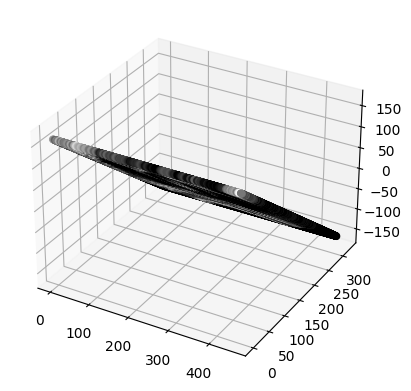

In [45]:

# Create the 3D scatter plot and set the color of each point to the corresponding pixel color
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_2d[:,0], points_2d[:,1], points_2d[:,2], c=colors/255.0, cmap='gray')
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the 3D volume of the prostate gland
prostate_volume = image


In [4]:
prostate_volume.shape

(455, 325, 46)

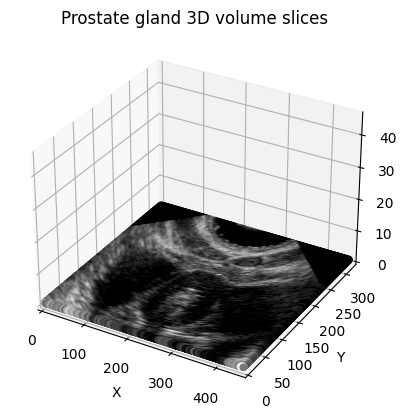

In [31]:

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the x, y, and z limits of the plot
x_len, y_len, z_len = prostate_volume.shape
ax.set_xlim(0, x_len)
ax.set_ylim(0, y_len)
ax.set_zlim(0, z_len)


# Loop over the z axis and plot the corresponding slice

x, y = np.meshgrid(np.arange(x_len), np.arange(y_len), indexing='ij')
slice_index = 0
# Create a 1D array of the slice values
slice_values = prostate_volume[:, :, slice_index]
color_values = slice_values.flatten()

# Create a 1D array of RGB colors corresponding to the intensity values
cmap = plt.cm.gray
norm = plt.Normalize(vmin=color_values.min(), vmax=color_values.max())
color_array = cmap(norm(color_values))

# Plot the transformed slice as a 3D scatter plot
ax.scatter(x, y, np.ones_like(x), c=color_array)
#ax.plot_surface(x, y, np.ones_like(x)*2, facecolors=plt.cm.gray(prostate_volume[:, :, 0]), shade=False)


# Set the title of the plot
ax.set_title("Prostate gland 3D volume slices")

# Set the labels for the x, y, and z axes
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Show the plot
plt.show()


NameError: name 'prostate_volume' is not defined

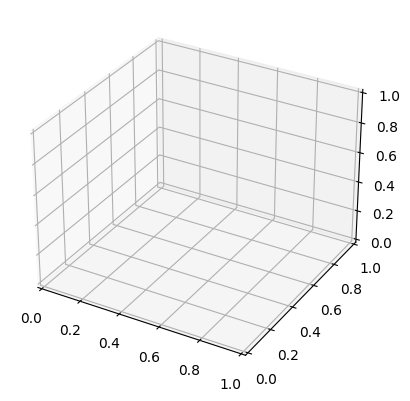

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the 3D volume of the prostate glandprostate_volume = np.load("prostate_volume.npy")

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the x, y, and z limits of the plot
x_len, y_len, z_len = prostate_volume.shape
ax.set_xlim(0, x_len)
ax.set_ylim(0, y_len)
ax.set_zlim(0, z_len)

# Define the transformation matrix for the oblique view
theta = np.deg2rad(0)
phi = np.deg2rad(-30)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [np.sin(theta), np.cos(theta), 0],
                            [0, 0, 1]])
rotation_matrix = np.dot(np.array([[1, 0, 0],
                                   [0, np.cos(phi), -np.sin(phi)],
                                   [0, np.sin(phi), np.cos(phi)]]), rotation_matrix)


# Define the coordinates of the slice
slice_index = 0
xx, yy = np.meshgrid(np.arange(x_len), np.arange(y_len), indexing='ij')
zz = np.ones_like(xx) * slice_index


# Apply the transformation matrix to the coordinates
xyz = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T
xyz = np.dot(xyz, rotation_matrix)

# Reshape the transformed coordinates and the slice values
xx, yy, zz = xyz[:, 0].reshape(xx.shape), xyz[:, 1].reshape(yy.shape), xyz[:, 2].reshape(zz.shape)
slice_values = prostate_volume[:, :, slice_index]


# Plot the transformed slice as a surface
ax.plot_surface(xx, yy, zz, facecolors=plt.cm.gray(slice_values), shade=False)

# Set the title of the plot
ax.set_title("Oblique view of a prostate gland 3D volume slice")

# Set the labels for the x, y, and z axes
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the 3D volume of the prostate glandprostate_volume = np.load("prostate_volume.npy")
# Load the 3D volume of the prostate gland
prostate_volume = image

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the x, y, and z limits of the plot
x_len, y_len, z_len = prostate_volume.shape
ax.set_xlim(0, x_len)
ax.set_ylim(0, y_len)
ax.set_zlim(0, z_len)

# Define the transformation matrix for the oblique view
theta = np.deg2rad(0)
phi = np.deg2rad(-45)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [np.sin(theta), np.cos(theta), 0],
                            [0, 0, 1]])
rotation_matrix = np.dot(np.array([[1, 0, 0],
                                   [0, np.cos(phi), -np.sin(phi)],
                                   [0, np.sin(phi), np.cos(phi)]]), rotation_matrix)


# Define the coordinates of the slice
slice_index = 0
xx, yy = np.meshgrid(np.arange(x_len), np.arange(y_len), indexing='ij')
zz = np.ones_like(xx) * slice_index


# Apply the transformation matrix to the coordinates
xyz = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T
xyz = np.dot(xyz, rotation_matrix)

# Reshape the transformed coordinates and the slice values
xx, yy, zz = xyz[:, 0].reshape(xx.shape), xyz[:, 1].reshape(yy.shape), xyz[:, 2].reshape(zz.shape)
slice_values = prostate_volume[:, :, slice_index]


# Plot the transformed slice as a surface

# Create a 1D array of the slice values
color_values = slice_values.flatten()

# Create a 1D array of RGB colors corresponding to the intensity values
cmap = plt.cm.gray
norm = plt.Normalize(vmin=color_values.min(), vmax=color_values.max())
color_array = cmap(norm(color_values))

# Plot the transformed slice as a 3D scatter plot
ax.scatter(xx, yy, zz, c=color_array, s = 0.07)

# Calculate the minimum and maximum z-coordinates of the transformed slice
z_min = zz.min()
z_max = zz.max()
# Calculate the minimum and maximum z-coordinates of the transformed slice
z_min = zz.min()
z_max = zz.max()
# x_min = xx.min()
# x_max = xx.max()
# y_min = yy.min()
# y_max = yy.max()
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)


# Set the limits of the z-axis to include the entire slice
ax.set_zlim(z_min, z_max)

# Set the limits of the z-axis to include the entire slice
ax.set_zlim(z_min, z_max)

# Set the title of the plot
ax.set_title("Oblique view of a prostate gland 3D volume slice")

# Set the labels for the x, y, and z axes
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Show the plot
plt.show()


In [ ]:
# Create re-slicing function
def reslice(image, theta, phi, slice_index):
    # Define the transformation matrix for the oblique view
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    rotation_matrix = np.dot(np.array([[1, 0, 0],
                                       [0, np.cos(phi), -np.sin(phi)],
                                       [0, np.sin(phi), np.cos(phi)]]), rotation_matrix)

    # Define the coordinates of the slice
    x_len, y_len, z_len = image.shape
    xx, yy = np.meshgrid(np.arange(x_len), np.arange(y_len), indexing='ij')
    zz = np.ones_like(xx) * slice_index

    # Apply the transformation matrix to the coordinates
    xyz = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T
    xyz = np.dot(xyz, rotation_matrix)

    # Reshape the transformed coordinates and the slice values
    xx, yy, zz = xyz[:, 0].reshape(xx.shape), xyz[:, 1].reshape(yy.shape), xyz[:, 2].reshape(zz.shape)

    # Extract the original slice values
    slice_values = image[:, :, slice_index]

    # Interpolate the slice values to the transformed coordinates
    slice_values = interpn((np.arange(x_len), np.arange(y_len)), slice_values, np.vstack((xx.flatten(), yy.flatten())).T, method='nearest', bounds_error=False, fill_value=None)


    return xx, yy, zz, slice_values

NameError: name 'y_max' is not defined

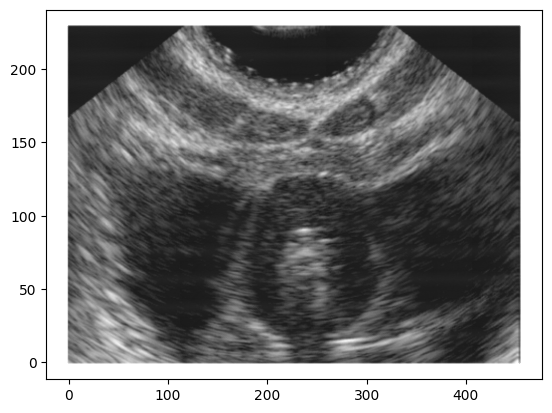

In [5]:
# Create a 1D array of the slice values
# Fill in the blanks with 0s
plt.scatter(xx, yy, c=color_array, s = 0.07)

In [6]:
image.shape

(455, 325, 46)

In [7]:
slice_values.shape

(455, 325)

In [22]:
xyz.shape

(147875, 3)

In [24]:
zz

array([[  0.        ,   0.70710678,   1.41421356, ..., 227.68838354,
        228.39549032, 229.1025971 ],
       [  0.        ,   0.70710678,   1.41421356, ..., 227.68838354,
        228.39549032, 229.1025971 ],
       [  0.        ,   0.70710678,   1.41421356, ..., 227.68838354,
        228.39549032, 229.1025971 ],
       ...,
       [  0.        ,   0.70710678,   1.41421356, ..., 227.68838354,
        228.39549032, 229.1025971 ],
       [  0.        ,   0.70710678,   1.41421356, ..., 227.68838354,
        228.39549032, 229.1025971 ],
       [  0.        ,   0.70710678,   1.41421356, ..., 227.68838354,
        228.39549032, 229.1025971 ]])